In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

sns.set(rc={'figure.figsize': (10,6)})

In [14]:
path = 'smmh.csv'
df = pd.read_csv(path)

In [15]:
df.columns = [c.strip() for c in df.columns]

In [16]:
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()


In [17]:
age_col = '1. What is your age?'
occ_col = '4. Occupation Status'
time_col = '8. What is the average time you spend on social media every day?'

In [18]:
def parse_time_to_hours(x):
    if pd.isna(x): return np.nan
    s = str(x).lower().strip()
    s = s.replace('hrs','hour').replace('hr','hour').replace('hours','hour')
    s = s.replace('mins','min').replace('minutes','min').replace('—','-').replace('–','-')
    if '-' in s:
        parts = s.split('-')
        nums = []
        for p in parts[:2]:
            pnum = ''.join(ch for ch in p if (ch.isdigit() or ch=='.'))
            try: nums.append(float(pnum))
            except: pass
        if len(nums)==2: return sum(nums)/2.0
    if 'min' in s:
        num = ''.join(ch for ch in s if (ch.isdigit() or ch=='.'))
        try: return float(num)/60.0
        except: return np.nan
    num = ''
    for ch in s:
        if (ch.isdigit() or ch=='.'): num += ch
        elif num: break
    if num:
        try: return float(num)
        except: return np.nan
    if '<' in s or 'less' in s or 'few' in s: return 0.5
    if 'many' in s or 'a lot' in s or 'lots' in s: return 5.0
    return np.nan


In [19]:
df['age'] = pd.to_numeric(df[age_col], errors='coerce')
df['daily_usage_hrs'] = df[time_col].apply(parse_time_to_hours)

In [20]:
likert_cols = [
 '9. How often do you find yourself using Social media without a specific purpose?',
 '10. How often do you get distracted by Social media when you are busy doing something?',
 '11. Do you feel restless if you havent used Social media in a while?',
 '12. On a scale of 1 to 5, how easily distracted are you?',
 '13. On a scale of 1 to 5, how much are you bothered by worries?',
 '14. Do you find it difficult to concentrate on things?',
 '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
 '17. How often do you look to seek validation from features of social media?',
 '18. How often do you feel depressed or down?',
 '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?',
 '20. On a scale of 1 to 5, how often do you face issues regarding sleep?'
]

In [21]:
for c in likert_cols:
    if c in df.columns:
        df[c+'_num'] = pd.to_numeric(df[c], errors='coerce')

In [22]:
print("Original rows:", len(df))

students_only = True
if students_only and (occ_col in df.columns):
    df = df[df[occ_col].str.contains('student', case=False, na=False)].copy()

print("Rows after student filter:", len(df))

print("\nMissing key fields:")
check = ['daily_usage_hrs','age'] + [c+'_num' for c in likert_cols if c in df.columns]
print(df[check].isnull().sum())

print("\nDaily usage stats:")
print(df['daily_usage_hrs'].describe())


Original rows: 481
Rows after student filter: 341

Missing key fields:
daily_usage_hrs                                                                                                             0
age                                                                                                                         0
9. How often do you find yourself using Social media without a specific purpose?_num                                        0
10. How often do you get distracted by Social media when you are busy doing something?_num                                  0
12. On a scale of 1 to 5, how easily distracted are you?_num                                                                0
13. On a scale of 1 to 5, how much are you bothered by worries?_num                                                         0
14. Do you find it difficult to concentrate on things?_num                                                                  0
15. On a scale of 1-5, how often do you compare

In [23]:
bins = [0,2,4,6,24]
labels = ['Low (0-2h)','Moderate (2-4h)','High (4-6h)','Very High (>6h)']
df['usage_group'] = pd.cut(df['daily_usage_hrs'], bins=bins, labels=labels, include_lowest=True)

numeric_cols = ['daily_usage_hrs','age'] + [c+'_num' for c in likert_cols if c+'_num' in df.columns]
numeric_cols = [c for c in numeric_cols if c in df.columns]
corr = df[numeric_cols].corr()

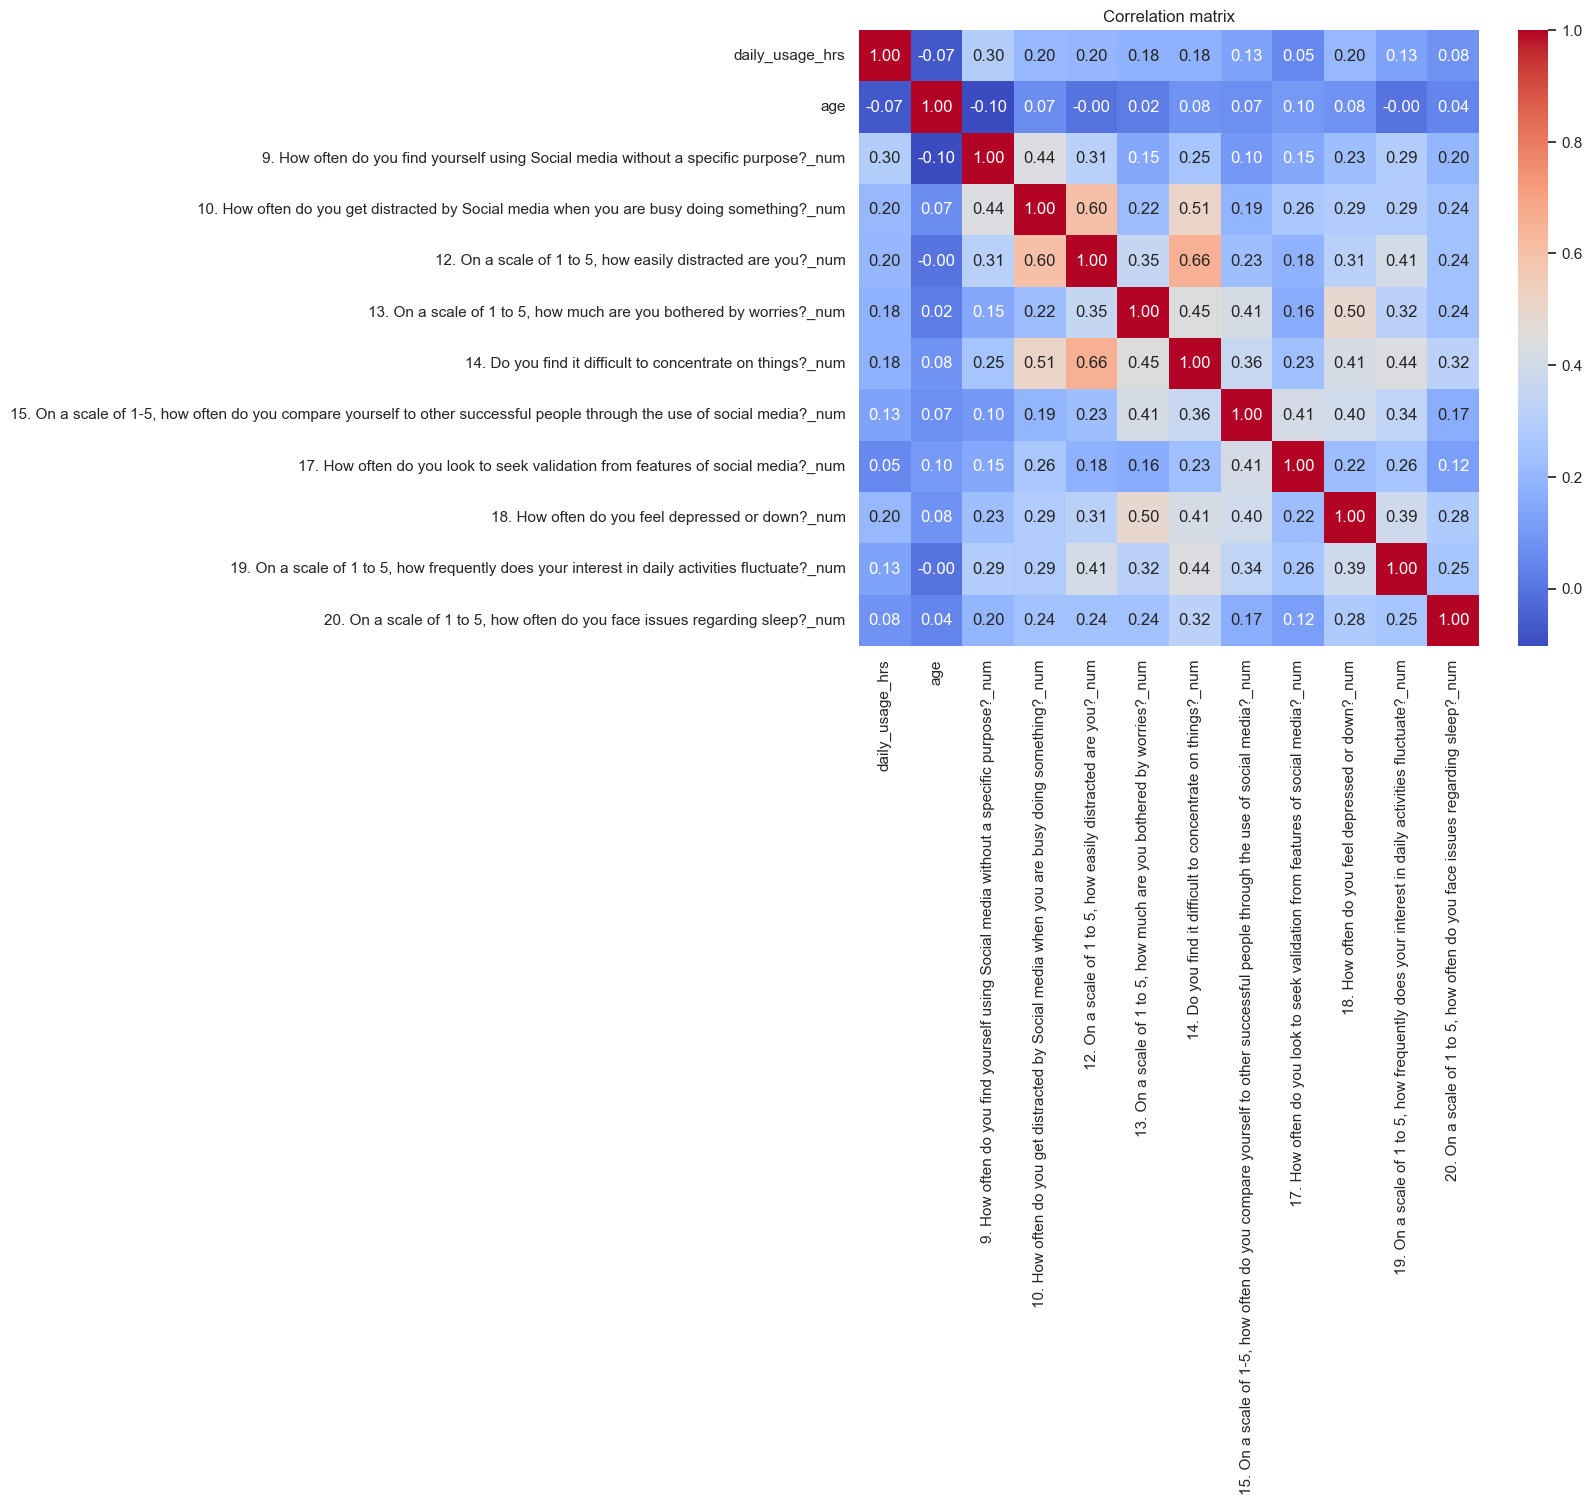

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

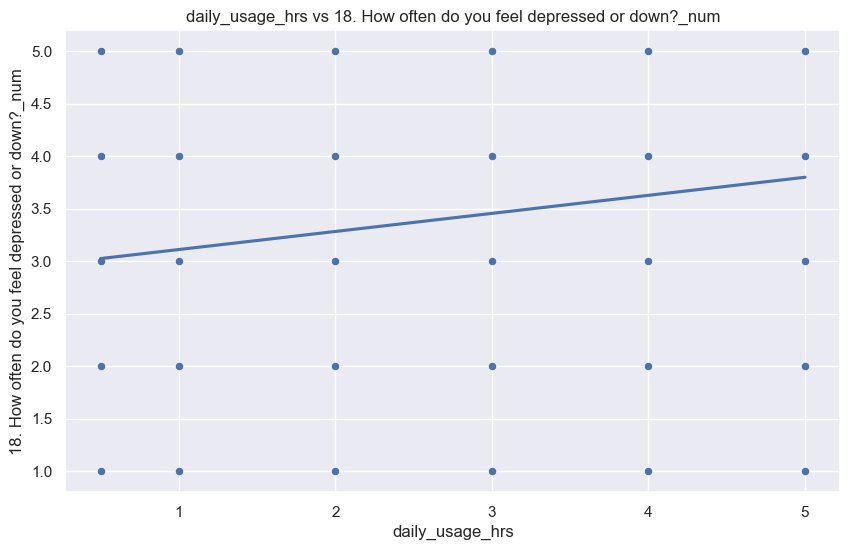

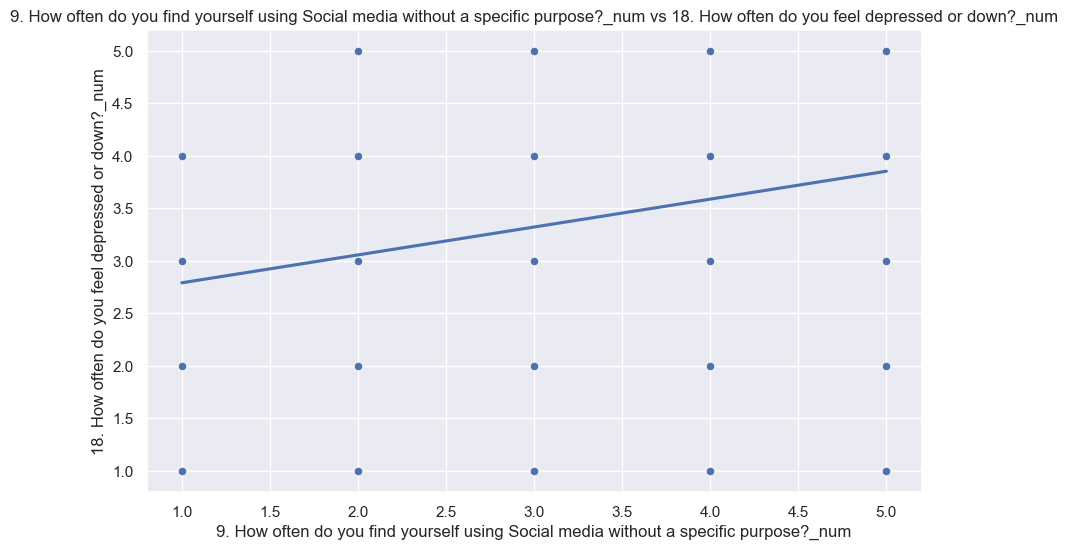

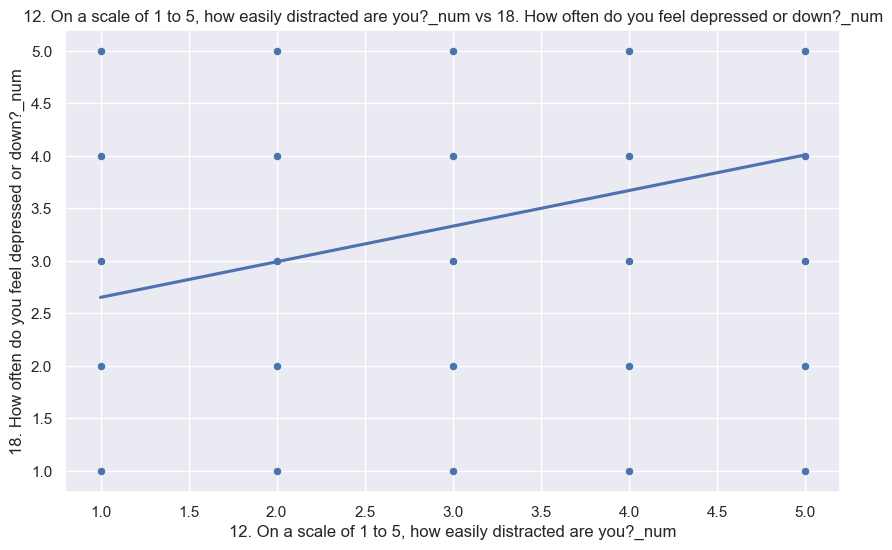

In [25]:
dep_col_num = '18. How often do you feel depressed or down?_num'
if dep_col_num in df.columns:
    targets = ['daily_usage_hrs','9. How often do you find yourself using Social media without a specific purpose?_num','12. On a scale of 1 to 5, how easily distracted are you?_num']
    for t in targets:
        if t in df.columns:
            plt.figure()
            sns.scatterplot(x=df[t], y=df[dep_col_num])
            sns.regplot(x=df[t], y=df[dep_col_num], scatter=False, ci=None)
            plt.title(f'{t} vs {dep_col_num}')
            plt.show()


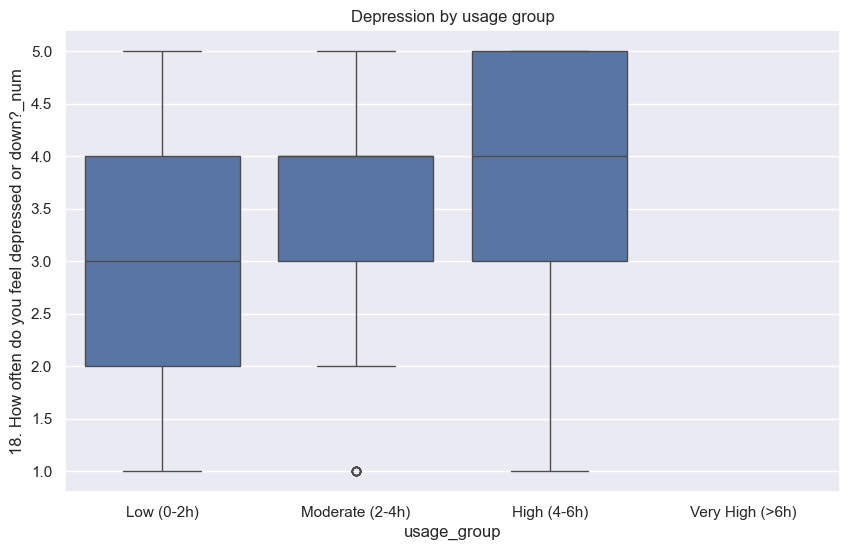

T-test Low vs High for 18. How often do you feel depressed or down?_num: t=-3.341, p=0.0010


In [27]:
plt.figure()
sns.boxplot(data=df, x='usage_group', y=dep_col_num)
plt.title('Depression by usage group')
plt.show()

low = df[df['usage_group']=='Low (0-2h)'][dep_col_num].dropna()
high = df[df['usage_group']=='High (4-6h)'][dep_col_num].dropna()
if len(low)>2 and len(high)>2:
    tstat, pval = ttest_ind(low, high, equal_var=False)
    print(f"T-test Low vs High for {dep_col_num}: t={tstat:.3f}, p={pval:.4f}")
else:
    print("Not enough samples for reliable t-test between Low and High groups.")


In [28]:
features = []
if 'daily_usage_hrs' in df.columns: features.append('daily_usage_hrs')
if 'age' in df.columns: features.append('age')
sleep_num = '20. On a scale of 1 to 5, how often do you face issues regarding sleep?_num'
if sleep_num in df.columns: features.append(sleep_num)


In [29]:
target = dep_col_num
if target in df.columns and len(features)>0:
    reg_df = df[features + [target]].dropna()
    if len(reg_df) > 10:
        X = reg_df[features].values
        y = reg_df[target].values
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
        lr = LinearRegression()
        lr.fit(X_train,y_train)
        y_pred = lr.predict(X_test)
        print("\nRegression R2:", r2_score(y_test,y_pred))
        print("Coefs:", dict(zip(features, lr.coef_)))
    else:
        print("Not enough rows for a reliable regression.")
else:
    print("Regression skipped: target or features missing.")

print("\nSummary:")
print("Sample size:", len(df))
print("Mean daily usage (hrs):", df['daily_usage_hrs'].mean())
if dep_col_num in df.columns:
    print("Mean depression score:", df[dep_col_num].mean())


Regression R2: -0.08767205678407075
Coefs: {'daily_usage_hrs': np.float64(0.16035892250433847), 'age': np.float64(0.015819254539313512), '20. On a scale of 1 to 5, how often do you face issues regarding sleep?_num': np.float64(0.28789184591124)}

Summary:
Sample size: 341
Mean daily usage (hrs): 3.2595307917888565
Mean depression score: 3.498533724340176


In [30]:
out_path = 'smmh_cleaned.csv'
save_cols = [c for c in df.columns if c in df.columns]
df[save_cols].to_csv(out_path, index=False)
print("Cleaned file saved to:", out_path)

Cleaned file saved to: smmh_cleaned.csv
